In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#Use GPUs to speed up code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [33]:
def plot_losses(loss,a,optimiser_tuning = True,lossF=None,lossG=None):
    """
    Function that plots the evolution of the loss function(s) over the epoch.
    Receives as arguments:
    - loss - The "Global" Loss function (list of values for each epoch);
    - a - the spin parameter (int);
    - lossF - the loss of the radial solution (list of values for each epoch);
    - lossG - the loss of the angular solution (list of values for each epoch);
    """
    plt.figure()
    plt.title(f"Loss over epoch for a={a}")
    # convert y-axis to Logarithmic scale
    plt.yscale("log")
    plt.plot(loss,label="total loss")
    if None not in (lossF, lossG):
        plt.plot(lossF,label="Loss of F")
        plt.plot(lossG,label="Loss of G")
    
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    if optimiser_tuning:
        plt.savefig(f"losses_a{a}_Adam.png")
    else:
        plt.savefig(f"losses_a{a}_LBFGS.png")
    
    plt.show()


In [34]:
def F_terms(a,w,A,s,m,x):
    """
    All these values were calculated by Mathematica.
    Calculates The F_i terms defined in the Appendix A, each one with shape (N_x,1).
    Receives as arguments:
    - a - the spin parameter, value between 0 and 0.5 (float);
    - w - the frequency of the QNM (parameter of the Neural Network);
    - A - the separation constant of thr Teukolsky equation (parameter of the Neural Network);
    - s - spin-weight (for tensor pertubations s = -2);
    - m - Spherical harmonic indicies l and m;
    - x: vector with dimensions (N_x,1) that defines the radial space.
    """

    # Important intermediate values:
    b = np.sqrt(1 - 4*a**2) # intermediate value )

    # F0 term:
    F0 = 2*w*(-1j + 1j*b - 2*a*m - 2j*s + 2*w - a**2*w + 2*b*w) + 2*(a**2*w**2 - 2*a*m*(1j + w) + 1j*(1 + s)*(1j*b + 2*(1 + b)*w))*x + \
    ((1 + b)*(1 - 2j*w)*(1 + s - 2j*w) - 4*a**3*m*w - 2*a**4*w**2 + 2*a*(1 + b)*m*(1j + 2*w) + \
    2*a**2*(-2 + 1j*(5 + b)*w + 2*(3 + b)*w**2 + 2j*s*(1j + w)))*x**2 - 2*A*(1 - x + a**2*x**2)

    # F1 term:
    F1 =  (2 - 2*x + 2*a**2*x**2)*(x*(2 - s*(-2 + x) - (2 + b + 2j*a*m)*x + 2*a**2*x**2) + 2j*w*(-1 + (1 - a**2 + b)*x**2))

    # F2 term:
    F2 = 2*x**2*(1 - x + a**2*x**2)**2

    return F0,F1,F2 

In [35]:
def G_terms(a,w,A,s,m,u):
    """
    Calculates The F_i terms defined in the Appendix A, each one with shape (N_x,1).
    Receives as arguments:
    - a - the spin parameter, value between 0 and 0.5 (float);
    - w - the frequency of the QNM (parameter of the Neural Network);
    - A - the separation constant of thr Teukolsky equation (parameter of the Neural Network).
    - s - spin-weight (for tensor pertubations s = -2);
    - m - Spherical harmonic indicies l and m;
    - u: vector with dimensions (N_u,1) that defines the angular space.
    """

    G0 = 4 * (A - (m + s*u)**2 -A * u**2 + (-1 + u**2) * (-s + 2 * a * (1 + s) * u * w - a**2 * w**2)) + (-1 +u)**2 * np.abs(m - s)**2 \
    + 2 * (-1 + u**2) * (1 + 2 * a * (1 + u)*  w) * np.abs(m + s) + (1 + u)**2 * np.abs(m + s)**2 + 2 * (-1 + u**2) * np.abs(m - s) * (1 + 2*a * (-1 + u) * w + np.abs(m + s))  
    
    G1 = -4* (u**2 -1 ) * (2 * (u + a * (-1 + u**2)* w) + (-1 + u) * np.abs(m - s) + (1 + u) * np.abs(m + s))

    G2 = - 4*(u**2 - 1)**2

    return G0,G1,G2

In [36]:
def gradients(outputs, inputs, order = 1):
    """
    Compute the derivatives of a complex function f(x) via automatic differentiation.

    -param outputs- PyTorch complex tensor of shape (N, 1) with the values of f(x)
    -param inputs-  PyTorch real tensor of shape (N, 1) with the values of x
    -param order-   Order of the derivative (default: 1)
    -return-        PyTorch complex tensor of shape (N, 1) with the values of f'(x)
    """
   
    re_outputs = torch.real(outputs)
    im_outputs = torch.imag(outputs)
    if order == 1:
        d_re = torch.autograd.grad(re_outputs, inputs, grad_outputs=torch.ones_like(re_outputs), create_graph=True)[0]
        d_im = torch.autograd.grad(im_outputs, inputs, grad_outputs=torch.ones_like(im_outputs), create_graph=True)[0]
        return d_re + (1j) * d_im
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [37]:
class NeuralNetwork(nn.Module): 
    """
    Defines both Neural Networks, for F and G. Returns the hard enforced values of both radial and angular functions.
    Receives as arguments:
    -l,m - Spherical harmonic indicies l and m;
    - input_size_x, input_size_u - The input size of each neural network (1)
    - hidden_layers - number of hidden layers
    - neurons_per_layer - number of neurons per each hidden layer
    - ouput_size - size of the output of the neural network(=2, separation of real and imaginary part)
    - n - Spherical harmonic indice n, as default we use the fundamental mode
    - s - spin-weight (for tensor pertubations s = -2)  
    """

    def __init__(self,l,m,input_size_x = 1, input_size_u = 1, hidden_layers = 3,neurons_per_layer = 200, output_size = 2 ,n = 0,s= -2):
        super(NeuralNetwork, self).__init__()
        
        #Spherical harmonic indicies l and m and the spin weigjt s
        self.l = torch.tensor(l)
        self.m = torch.tensor(m)
        self.s = torch.tensor(s) 

        #definition of the activation of the NN
        activation = nn.Tanh()

        #Initialization of the eigenvalues of omega and A to sensible values
        self.A_real = torch.nn.Parameter(data = torch.tensor(float(l*(l+1)-s*(s+1) ) ), requires_grad = True)
        self.A_img = torch.nn.Parameter(data = torch.tensor(0.0), requires_grad = True)

        self.w_real = torch.nn.Parameter(data = torch.tensor(0.7), requires_grad = True)
        self.w_img = torch.nn.Parameter(data = torch.tensor(-0.1), requires_grad = True)


        #Network for the Radial Equation (depends on x)
        self.x_network = nn.Sequential()
        self.x_network.add_module("Input",nn.Linear(input_size_x, neurons_per_layer))
        self.x_network.add_module("Input activatation",activation)
        for i in range(hidden_layers):
            self.x_network.add_module(f"Hidden layer number: {i+1} ",nn.Linear(neurons_per_layer, neurons_per_layer))
            self.x_network.add_module(f"Hidden {i+1} activation",activation)
        self.x_network.add_module("Output", nn.Linear(neurons_per_layer, output_size))
        
        #Network for the Angular Equation (depends on u)
        self.u_network = nn.Sequential()
        self.u_network.add_module("Input",nn.Linear(input_size_u, neurons_per_layer))
        self.u_network.add_module("Input activatation",activation)
        for i in range(hidden_layers):
            self.u_network.add_module(f"Hidden layer number: {i+1} ",nn.Linear(neurons_per_layer, neurons_per_layer))
            self.u_network.add_module(f"Hidden {i+1} activation",activation)
        self.u_network.add_module("Output", nn.Linear(neurons_per_layer, output_size))

        #Random initialization of the network parameters:
        """
        
        # We use the same seed to ensure that the same random numbers are used for both networks
        # Plus, we use the kaiming initialization for both networks
        # std = gain / sqrt(n_input)
        # for tanh, gain = 5/3

        std_x = 5/3 / np.sqrt(100)
        std_u = 5/3 / np.sqrt(100)
        
        """
        torch.manual_seed(42)
        
        for z in self.x_network.modules():
            if isinstance(z,nn.Linear):
                nn.init.normal_(z.weight,mean=0,std=0.05)
                nn.init.constant_(z.bias,val=0)
        
        for z in self.u_network.modules():
            if isinstance(z,nn.Linear):
                nn.init.normal_(z.weight,mean=0,std=0.01)
                nn.init.constant_(z.bias,val=0)
        



    def forward(self, x, u):
        """
        Evaluates the NN and applies the hard enforcement of normalization
        Receives as arguments:
        x,u : the vectors with dimensions (N_x,1) and (N_u,1) that defined 
            the radial and angular space, respectively. 
        """
        x_output = self.x_network(x)
        u_output = self.u_network(u)

        #Clone f and g respectively, turn two collumns into a complex number and turn into a [N_x,1] matrix
        f_complex_tensor = torch.view_as_complex(x_output)
        g_complex_tensor = torch.view_as_complex(u_output)
 

        #After joining them, one needs to hard enforce f and g:
        f_new = ((torch.exp(x.view(-1)-1)-1)*f_complex_tensor + 1).view(-1,1) #Hard Enforcement for f(x)
        g_new = ((torch.exp(u.view(-1)+1)-1)*g_complex_tensor + 1).view(-1,1) #Hard Enforcement for g(u)

    
        
        return f_new, g_new

In [38]:
class CustomLoss(nn.Module):
    """
    Returns the Loss Function, defined here specifically for the Teukolsky Equation
    Receives as arguments:
    - Neural Network - interpolator of the NN;
    - a - the spin parameter, value between 0 and 0.5 (float);
    - r_plus - outer horizon radii of the Kerr metric (float);
    """
    def __init__(self,NeuralNetwork,a):
        super(CustomLoss,self).__init__()

        self.NeuralNetwork = NeuralNetwork
        self.a = torch.tensor(a)
        
        self.l = NeuralNetwork.l
        self.m = NeuralNetwork.m
        self.s = NeuralNetwork.s
    
    def forward(self,x,u):

        #Recover eigenvalues
        w_real = self.NeuralNetwork.w_real
        w_img = self.NeuralNetwork.w_img
        A_real = self.NeuralNetwork.A_real
        A_img = self.NeuralNetwork.A_img

        #To call the function F_terms and G_terms, we need to convert the eigenvalues to complex numbers
        w = torch.view_as_complex(torch.stack((w_real,w_img),dim=0))
        A = torch.view_as_complex(torch.stack((A_real,A_img),dim=0))

        #Compute some commom expressions
        a = self.a
        m = self.m
        s = self.s

        # Calculate the F ang G terms for the Loss Function
        F0, F1, F2 = F_terms(a,w,A,s,m,x)
        G0, G1, G2 = G_terms(a,w,A,s,m,u)
        
        #Recover the value of the hard enforced f and g
        f,g = self.NeuralNetwork(x,u)

        # Compute the derivatives of hard enforced f and g needed for the Loss Function
        dfdt = gradients(outputs = f, inputs = x)
        d2fdt2 = gradients(outputs = dfdt, inputs = x)
        dgdt = gradients(outputs = g, inputs = u)
        d2gdt2 = gradients(outputs = dgdt, inputs = u)

        #Finally compute the Loss of f and g
        lossF = torch.mean(torch.abs(F2*d2fdt2 + F1*dfdt + F0*f))
        lossG = torch.mean(torch.abs(G2*d2gdt2 + G1*dgdt + G0*g))

        #Define the overall loss
        W = 10 #  parameterization factor that ensures that  
                # both losses are on the same order of magnitude

        loss = W*lossF + lossG

        return loss

In [39]:
#Comparison with Leaver's results:
def print_results(w_real_list,w_img_list):
    """
    Function that prints the results of the model and compares them with Leaver's results
    Args:
        w_real_list (list): list of real values of w
        w_img_list (list): list of imaginary values of w
    Returns:
        None
    """
    Leaver_real = np.array([0.74734, 0.75025, 0.75936 ,0.77611,0.80384,0.82401,0.84451,0.85023])
    Leaver_img = np.array([-0.17793,-0.17740,-0.17565,-0.17199,-0.16431,-0.15697,-0.14707,-0.14365])

    error_real = 100*(w_real_list - Leaver_real)/Leaver_real
    #print("Percentual error for the real frequency:\n",np.abs(error_real[:,None]))

    error_img = 100*(w_img_list - Leaver_img)/Leaver_img
    #print("Percentual error for the imaginary frequency:\n",np.abs(error_img[:,None]))


    #Print the results for each entry all each in one line, printing the real and imaginary part of w, the error for the real and imaginary part of w and the average error:
    for i in range(len(w_real_list)):
        average_error = (np.abs(error_real[i]) + np.abs(error_img[i]))/2
        print(f"Real part of w: {w_real_list[i]:.5f}, Imaginary part of w: {w_img_list[i]:.5f}, Error real: {error_real[i]:.5f}%, Error imaginary: {error_img[i]:.5f}%, Average error: {average_error:.5f}%")

Adam: a = 0.0, loss at iteration 100 = 0.43541
Adam: a = 0.0, loss at iteration 200 = 0.66522
Adam: a = 0.0, loss at iteration 300 = 0.32090
Adam: a = 0.0, loss at iteration 400 = 0.32248
Adam: a = 0.0, loss at iteration 500 = 0.65699
Adam: a = 0.0, loss at iteration 600 = 0.70014
Adam: a = 0.0, loss at iteration 700 = 0.22031
Adam: a = 0.0, loss at iteration 800 = 0.34838
Adam: a = 0.0, loss at iteration 900 = 0.14346
Adam: a = 0.0, loss at iteration 1000 = 0.13307
LFBGS: a = 0.0, loss at iteration 10 = 0.05233
LFBGS: a = 0.0, loss at iteration 20 = 0.05034


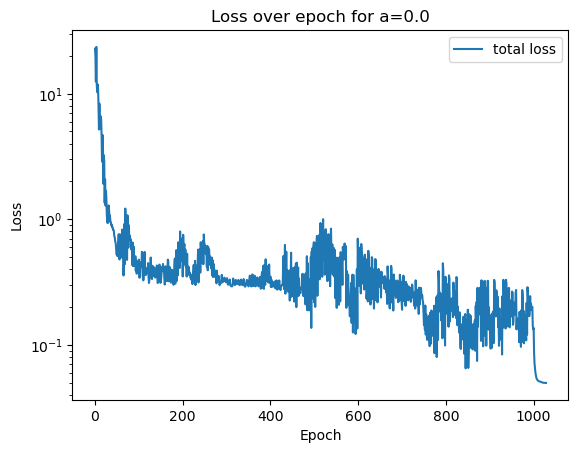

For a = 0.0, omega converged to w = 0.74966 -0.17772i  and to A = 4.00000 + -0.00000i
 
Adam: a = 0.1, loss at iteration 100 = 0.65442
Adam: a = 0.1, loss at iteration 200 = 0.35175
Adam: a = 0.1, loss at iteration 300 = 0.29957
Adam: a = 0.1, loss at iteration 400 = 0.32177
Adam: a = 0.1, loss at iteration 500 = 0.39734
Adam: a = 0.1, loss at iteration 600 = 0.18365
Adam: a = 0.1, loss at iteration 700 = 0.23451
Adam: a = 0.1, loss at iteration 800 = 0.35523
Adam: a = 0.1, loss at iteration 900 = 0.09007
Adam: a = 0.1, loss at iteration 1000 = 0.30770
LFBGS: a = 0.1, loss at iteration 10 = 0.07061
LFBGS: a = 0.1, loss at iteration 20 = 0.06340
LFBGS: a = 0.1, loss at iteration 30 = 0.05594
LFBGS: a = 0.1, loss at iteration 40 = 0.04958


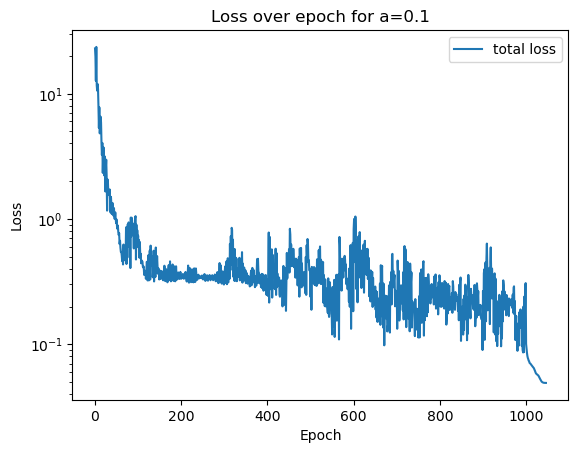

For a = 0.1, omega converged to w = 0.75224 -0.17909i  and to A = 3.99839 + 0.00088i
 
Adam: a = 0.2, loss at iteration 100 = 0.48965
Adam: a = 0.2, loss at iteration 200 = 0.36741
Adam: a = 0.2, loss at iteration 300 = 0.35170
Adam: a = 0.2, loss at iteration 400 = 0.58393
Adam: a = 0.2, loss at iteration 500 = 0.44351
Adam: a = 0.2, loss at iteration 600 = 0.25287
Adam: a = 0.2, loss at iteration 700 = 0.29449
Adam: a = 0.2, loss at iteration 800 = 0.25022
Adam: a = 0.2, loss at iteration 900 = 0.18335
Adam: a = 0.2, loss at iteration 1000 = 0.26422
LFBGS: a = 0.2, loss at iteration 10 = 0.08539
LFBGS: a = 0.2, loss at iteration 20 = 0.08140
LFBGS: a = 0.2, loss at iteration 30 = 0.07538
LFBGS: a = 0.2, loss at iteration 40 = 0.07439
LFBGS: a = 0.2, loss at iteration 50 = 0.07366
LFBGS: a = 0.2, loss at iteration 60 = 0.07325


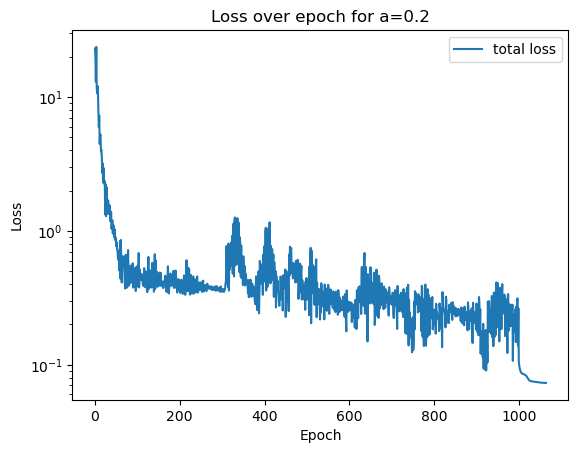

For a = 0.2, omega converged to w = 0.76196 -0.17864i  and to A = 3.99275 + 0.00379i
 
Adam: a = 0.3, loss at iteration 100 = 0.65281
Adam: a = 0.3, loss at iteration 200 = 0.55316
Adam: a = 0.3, loss at iteration 300 = 0.39659
Adam: a = 0.3, loss at iteration 400 = 0.82374
Adam: a = 0.3, loss at iteration 500 = 0.67372
Adam: a = 0.3, loss at iteration 600 = 0.35089
Adam: a = 0.3, loss at iteration 700 = 0.26037
Adam: a = 0.3, loss at iteration 800 = 0.21516
Adam: a = 0.3, loss at iteration 900 = 0.24104
Adam: a = 0.3, loss at iteration 1000 = 0.13046
LFBGS: a = 0.3, loss at iteration 10 = 0.10417
LFBGS: a = 0.3, loss at iteration 20 = 0.10232
LFBGS: a = 0.3, loss at iteration 30 = 0.08957
LFBGS: a = 0.3, loss at iteration 40 = 0.08602
LFBGS: a = 0.3, loss at iteration 50 = 0.08401
LFBGS: a = 0.3, loss at iteration 60 = 0.08258
LFBGS: a = 0.3, loss at iteration 70 = 0.07967
LFBGS: a = 0.3, loss at iteration 80 = 0.05771
LFBGS: a = 0.3, loss at iteration 90 = 0.05601


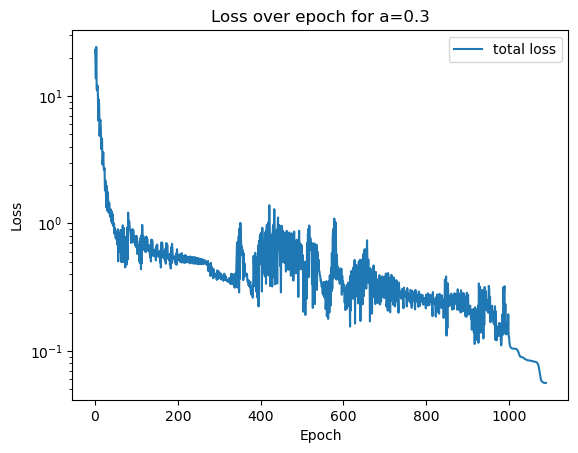

For a = 0.3, omega converged to w = 0.77547 -0.17256i  and to A = 3.98250 + 0.00842i
 
Adam: a = 0.4, loss at iteration 100 = 0.71949
Adam: a = 0.4, loss at iteration 200 = 0.55113
Adam: a = 0.4, loss at iteration 300 = 0.40880
Adam: a = 0.4, loss at iteration 400 = 0.52631
Adam: a = 0.4, loss at iteration 500 = 0.37905
Adam: a = 0.4, loss at iteration 600 = 0.39438
Adam: a = 0.4, loss at iteration 700 = 0.29651
Adam: a = 0.4, loss at iteration 800 = 0.25043
Adam: a = 0.4, loss at iteration 900 = 0.19735
Adam: a = 0.4, loss at iteration 1000 = 0.28665
LFBGS: a = 0.4, loss at iteration 10 = 0.09032
LFBGS: a = 0.4, loss at iteration 20 = 0.07630
LFBGS: a = 0.4, loss at iteration 30 = 0.05588
LFBGS: a = 0.4, loss at iteration 40 = 0.04684
LFBGS: a = 0.4, loss at iteration 50 = 0.04400
LFBGS: a = 0.4, loss at iteration 60 = 0.04281
LFBGS: a = 0.4, loss at iteration 70 = 0.04162
LFBGS: a = 0.4, loss at iteration 80 = 0.02625
LFBGS: a = 0.4, loss at iteration 90 = 0.01959
LFBGS: a = 0.4, los

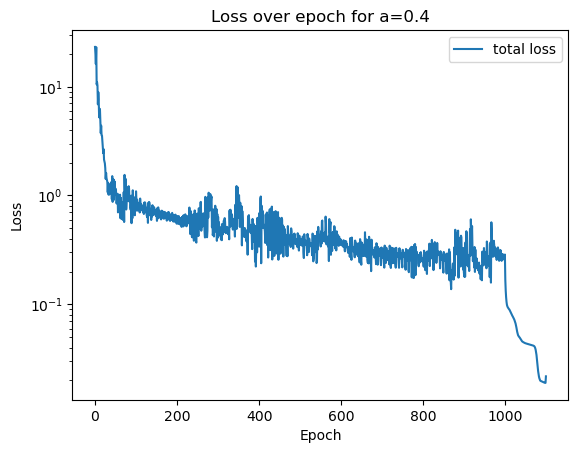

For a = 0.4, omega converged to w = 0.80453 -0.16371i  and to A = 3.96658 + 0.01487i
 
Adam: a = 0.45, loss at iteration 100 = 1.37215
Adam: a = 0.45, loss at iteration 200 = 1.95097
Adam: a = 0.45, loss at iteration 300 = 0.98570
Adam: a = 0.45, loss at iteration 400 = 0.39962
Adam: a = 0.45, loss at iteration 500 = 0.50049
Adam: a = 0.45, loss at iteration 600 = 0.35172
Adam: a = 0.45, loss at iteration 700 = 0.18652
Adam: a = 0.45, loss at iteration 800 = 0.34684
Adam: a = 0.45, loss at iteration 900 = 0.31664
Adam: a = 0.45, loss at iteration 1000 = 0.29858
LFBGS: a = 0.45, loss at iteration 10 = 0.08217
LFBGS: a = 0.45, loss at iteration 20 = 0.07445
LFBGS: a = 0.45, loss at iteration 30 = 0.04721
LFBGS: a = 0.45, loss at iteration 40 = 0.04162
LFBGS: a = 0.45, loss at iteration 50 = 0.04077


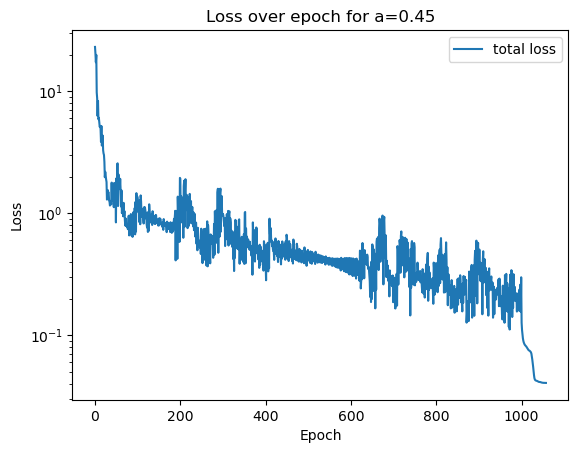

For a = 0.45, omega converged to w = 0.82415 -0.15634i  and to A = 3.95464 + 0.01838i
 
Adam: a = 0.49, loss at iteration 100 = 1.50796
Adam: a = 0.49, loss at iteration 200 = 1.38767
Adam: a = 0.49, loss at iteration 300 = 0.76845
Adam: a = 0.49, loss at iteration 400 = 1.14530
Adam: a = 0.49, loss at iteration 500 = 0.62626
Adam: a = 0.49, loss at iteration 600 = 0.81575
Adam: a = 0.49, loss at iteration 700 = 0.69101
Adam: a = 0.49, loss at iteration 800 = 0.66998
Adam: a = 0.49, loss at iteration 900 = 0.52725
Adam: a = 0.49, loss at iteration 1000 = 0.53030
LFBGS: a = 0.49, loss at iteration 10 = 0.36003
LFBGS: a = 0.49, loss at iteration 20 = 0.34168
LFBGS: a = 0.49, loss at iteration 30 = 0.32434
LFBGS: a = 0.49, loss at iteration 40 = 0.30055
LFBGS: a = 0.49, loss at iteration 50 = 0.24050
LFBGS: a = 0.49, loss at iteration 60 = 0.18527
LFBGS: a = 0.49, loss at iteration 70 = 0.15185
LFBGS: a = 0.49, loss at iteration 80 = 0.13959
LFBGS: a = 0.49, loss at iteration 90 = 0.13859

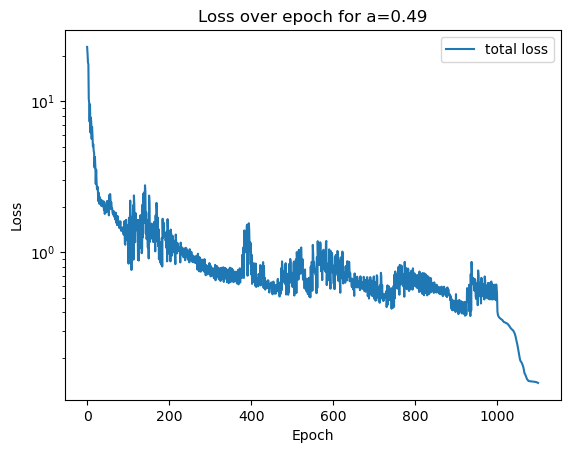

For a = 0.49, omega converged to w = 0.84396 -0.14639i  and to A = 3.94327 + 0.02104i
 
Adam: a = 0.4999, loss at iteration 100 = 2.37905
Adam: a = 0.4999, loss at iteration 200 = 2.19421
Adam: a = 0.4999, loss at iteration 300 = 1.62665
Adam: a = 0.4999, loss at iteration 400 = 1.40316
Adam: a = 0.4999, loss at iteration 500 = 1.30964
Adam: a = 0.4999, loss at iteration 600 = 1.19721
Adam: a = 0.4999, loss at iteration 700 = 1.17451
Adam: a = 0.4999, loss at iteration 800 = 1.41934
Adam: a = 0.4999, loss at iteration 900 = 1.01788
Adam: a = 0.4999, loss at iteration 1000 = 0.91290
LFBGS: a = 0.4999, loss at iteration 10 = 0.69325
LFBGS: a = 0.4999, loss at iteration 20 = 0.62296
LFBGS: a = 0.4999, loss at iteration 30 = 0.55222
LFBGS: a = 0.4999, loss at iteration 40 = 0.51584
LFBGS: a = 0.4999, loss at iteration 50 = 0.50018
LFBGS: a = 0.4999, loss at iteration 60 = 0.46123
LFBGS: a = 0.4999, loss at iteration 70 = 0.40840
LFBGS: a = 0.4999, loss at iteration 80 = 0.38071
LFBGS: a = 

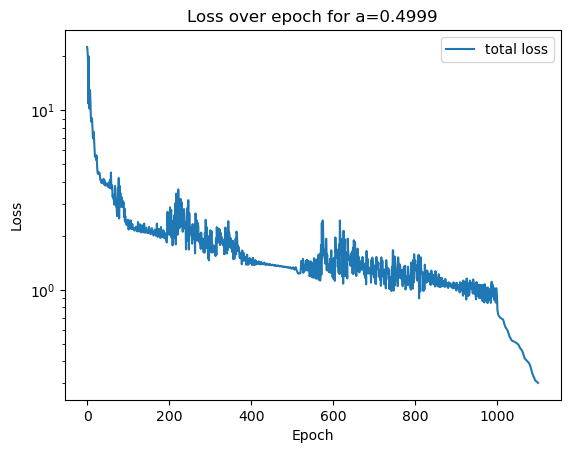

For a = 0.4999, omega converged to w = 0.64163 -0.09927i  and to A = 3.96588 + 0.01108i
 


In [40]:
# Set double precision as standard for torch
#torch.set_default_dtype(torch.float32)

# sample locations over the problem domain
N_x = 100 
N_u = 100
#Here I define x = 1 / r. However, I define it in a domain that goes from r = r_plus to r = infinity
# This means that x goes from 0 to 1/ r_plus -> Hence I will define each spacial domain for each a
u = torch.linspace(-1,1,N_u).view(-1,1).requires_grad_(True)

a_k_list = [0.0,0.1,0.2,0.3,0.4,0.45,0.49,0.4999]
#a_k_list = [0.0]

#Extract List of real and imaginary values of w
w_real_list = []
w_img_list = [] 

for a in a_k_list:

    #Define the spacial domain for each a
    r_plus = (1 + np.sqrt(1-4*a**2)) / 2
    x = torch.linspace(0,1/r_plus,N_x).view(-1,1).requires_grad_(True)
    
    # define the neural network to train
    l,m = 2,0
    model = NeuralNetwork(l,m)

    # Add Parameters to the optimisers (We use ADAM for the first 1000 iterations and LBFGS for the rest, avoiding local minima and then fine tuning the model)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.005)
    #We also do a decay of the learning rate for the ADAM optimiser
    optimiser_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimiser, gamma = 0.999) 
    optimiser_tuning = torch.optim.LBFGS(model.parameters(), lr = 0.01)
    
    #Initialize the model of the loss
    model_loss = CustomLoss(model,a)
    
    #Initialize (empty lists) that store values for plots for each a
    loss_list = []

    #Train the model with the ADAM optimiser
    for i in range(1000): 
        optimiser.zero_grad()

        loss = model_loss(x,u)

        # backpropagate joint loss, take optimiser step        
        loss.backward()
        optimiser.step() 
        optimiser_decay.step()

        #record values of loss function
        loss_list.append(loss.item())

        #Print the loss every 100 iterations
        if((i+1)%100 == 0):
            print(f"Adam: a = {a}, loss at iteration {i+1} = {loss.item():.5f}")


    #Define the closure for the LBFGS optimiser
    def closure():
        optimiser_tuning.zero_grad()
        loss = model_loss(x,u)
        loss.backward()
        return loss
    
    #Train the model with the fine tuning optimiser
    for i in range(100): 
        optimiser_tuning.step(closure)

        #record values of loss function
        loss_list.append(closure().item())
        #Print the loss every 10 iterations
        if((i+1)%10 == 0):
            print(f"LFBGS: a = {a}, loss at iteration {i+1} = {closure().item():.5f}")
        
        # If the two last values of the loss are the same, within a tolerance of 1e-5, we stop the training:
        if i > 0 and abs(loss_list[-1] - loss_list[-2]) < 1e-5:
            break
    
    #Plot of the losses for each interesting a:

    plot_losses(loss_list, a)
    print(f"For a = {a}, omega converged to w = {model.w_real.item():.5f} {model.w_img.item():.5f}i  and to A = {model.A_real.item():.5f} + {model.A_img.item():.5f}i")
    print(f" ")
    #Extract List of real and imaginary values of w
    w_real_list.append(model.w_real.item())
    w_img_list.append(model.w_img.item())

In [41]:
# Print the results for 1000 epochs of Adam and 100 iterations of the LBFGS optimiser:
print_results(np.array(w_real_list),np.array(w_img_list))

Real part of w: 0.74966, Imaginary part of w: -0.17772, Error real: 0.31022%, Error imaginary: -0.11803%, Average error: 0.21412%
Real part of w: 0.75224, Imaginary part of w: -0.17909, Error real: 0.26550%, Error imaginary: 0.95050%, Average error: 0.60800%
Real part of w: 0.76196, Imaginary part of w: -0.17864, Error real: 0.34299%, Error imaginary: 1.70081%, Average error: 1.02190%
Real part of w: 0.77547, Imaginary part of w: -0.17256, Error real: -0.08301%, Error imaginary: 0.33180%, Average error: 0.20740%
Real part of w: 0.80453, Imaginary part of w: -0.16371, Error real: 0.08601%, Error imaginary: -0.36411%, Average error: 0.22506%
Real part of w: 0.82415, Imaginary part of w: -0.15634, Error real: 0.01759%, Error imaginary: -0.39848%, Average error: 0.20804%
Real part of w: 0.84396, Imaginary part of w: -0.14639, Error real: -0.06480%, Error imaginary: -0.46059%, Average error: 0.26269%
Real part of w: 0.64163, Imaginary part of w: -0.09927, Error real: -24.53450%, Error imagi

Now we try the same only with the LBFGS optimizer:

LFBGS: a = 0.4999, loss at iteration 1 = 11.99546
LFBGS: a = 0.4999, loss at iteration 10 = 4.19887
LFBGS: a = 0.4999, loss at iteration 20 = 3.98283
LFBGS: a = 0.4999, loss at iteration 30 = 2.54821
LFBGS: a = 0.4999, loss at iteration 40 = 1.80273
LFBGS: a = 0.4999, loss at iteration 50 = 1.27449
LFBGS: a = 0.4999, loss at iteration 60 = 1.03015
LFBGS: a = 0.4999, loss at iteration 70 = 0.82953
LFBGS: a = 0.4999, loss at iteration 80 = 0.69320
LFBGS: a = 0.4999, loss at iteration 90 = 0.63815
LFBGS: a = 0.4999, loss at iteration 100 = 0.54716
LFBGS: a = 0.4999, loss at iteration 110 = 0.45369
LFBGS: a = 0.4999, loss at iteration 120 = 0.40802
LFBGS: a = 0.4999, loss at iteration 130 = 0.36444
LFBGS: a = 0.4999, loss at iteration 140 = 0.33016
LFBGS: a = 0.4999, loss at iteration 150 = 0.25608
LFBGS: a = 0.4999, loss at iteration 160 = 0.22085
LFBGS: a = 0.4999, loss at iteration 170 = 0.20374
LFBGS: a = 0.4999, loss at iteration 180 = 0.19570
LFBGS: a = 0.4999, loss at iteration 190 

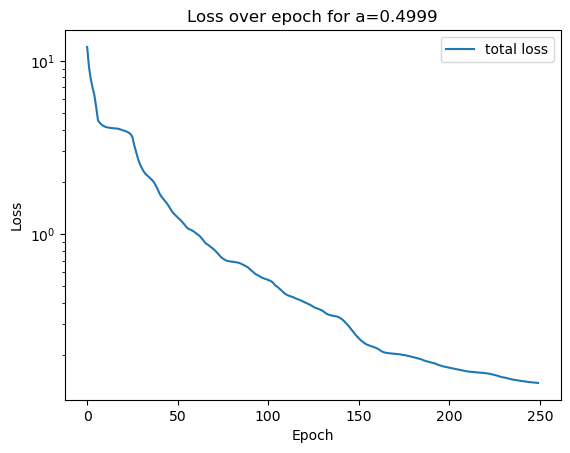

For a = 0.4999, omega converged to w = 0.85096 -0.14476i  and to A = 3.93622 + 0.02302i
 


In [53]:
# Set double precision as standard for torch
#torch.set_default_dtype(torch.float32)

# sample locations over the problem domain
N_x = 100 
N_u = 100
#Here I define x = 1 / r. However, I define it in a domain that goes from r = r_plus to r = infinity
# This means that x goes from 0 to 1/ r_plus -> Hence I will define each spacial domain for each a
u = torch.linspace(-1,1,N_u).view(-1,1).requires_grad_(True)

#a_k_list = [0.0,0.1,0.2,0.3,0.4,0.45,0.49,0.4999]
a_k_list = [0.4999]

#Extract List of real and imaginary values of w
w_real_list_LBFGS = []
w_img_list_LBFGS = [] 

for a in a_k_list:

    #Define the spacial domain for each a
    r_plus = (1 + np.sqrt(1-4*a**2)) / 2
    x = torch.linspace(0,1/r_plus,N_x).view(-1,1).requires_grad_(True)
    
    # define the neural network to train
    l,m = 2,0
    model = NeuralNetwork(l,m)

    # Add parameters to L-BFGS optimizer
    optimiser_tuning = torch.optim.LBFGS(model.parameters(), lr = 0.01)
    
    #Initialize the model of the loss
    model_loss = CustomLoss(model,a)
    
    #Initialize (empty lists) that store values for plots for each a
    loss_list = []

    #Define the closure for the LBFGS optimiser
    def closure():
        optimiser_tuning.zero_grad()
        loss = model_loss(x,u)
        loss.backward()
        return loss
    
    #Train the model with the fine tuning optimiser
    for i in range(250): 
        optimiser_tuning.step(closure)

        #record values of loss function
        loss_list.append(closure().item())
        #Print the loss every 10 iterations
        if(((i+1)%10 == 0) or (i == 0) ):
            
            print(f"LFBGS: a = {a}, loss at iteration {i+1} = {closure().item():.5f}")

            """
            # If the two last values of the loss are the same, within a tolerance of 1e-5, we stop the training:
            if i > 0 and abs(loss_list[-1] - loss_list[-10]) < 1e-5:
                break
            
            """
    

    
    #Plot of the losses for each interesting a:

    plot_losses(loss_list, a, optimiser_tuning = False)
    print(f"For a = {a}, omega converged to w = {model.w_real.item():.5f} {model.w_img.item():.5f}i  and to A = {model.A_real.item():.5f} + {model.A_img.item():.5f}i")
    print(f" ")
    #Extract List of real and imaginary values of w
    w_real_list_LBFGS.append(model.w_real.item())
    w_img_list_LBFGS.append(model.w_img.item())

In [54]:
# Print the results for 250 iterations of the LBFGS optimiser:
#Comparison with Leaver's results:
def print_results_extra(w_real_list,w_img_list):
    """
    Function that prints the results of the model and compares them with Leaver's results
    Args:
        w_real_list (list): list of real values of w
        w_img_list (list): list of imaginary values of w
    Returns:
        None
    """
    Leaver_real = np.array([0.85023])
    Leaver_img = np.array([-0.14365])

    error_real = 100*(w_real_list - Leaver_real)/Leaver_real
    #print("Percentual error for the real frequency:\n",np.abs(error_real[:,None]))

    error_img = 100*(w_img_list - Leaver_img)/Leaver_img
    #print("Percentual error for the imaginary frequency:\n",np.abs(error_img[:,None]))


    #Print the results for each entry all each in one line, printing the real and imaginary part of w, the error for the real and imaginary part of w and the average error:
    for i in range(len(w_real_list)):
        average_error = (np.abs(error_real[i]) + np.abs(error_img[i]))/2
        print(f"Real part of w: {w_real_list[i]:.5f}, Imaginary part of w: {w_img_list[i]:.5f}, Error real: {error_real[i]:.5f}%, Error imaginary: {error_img[i]:.5f}%, Average error: {average_error:.5f}%")
print_results_extra(np.array(w_real_list_LBFGS),np.array(w_img_list_LBFGS))

Real part of w: 0.85096, Imaginary part of w: -0.14476, Error real: 0.08573%, Error imaginary: 0.77468%, Average error: 0.43021%


LFBGS: a = 0.0, loss at iteration 1 = 11.41821
LFBGS: a = 0.0, loss at iteration 10 = 1.52933
LFBGS: a = 0.0, loss at iteration 20 = 1.21811
LFBGS: a = 0.0, loss at iteration 30 = 1.07553
LFBGS: a = 0.0, loss at iteration 40 = 0.85890
LFBGS: a = 0.0, loss at iteration 50 = 0.33835
LFBGS: a = 0.0, loss at iteration 60 = 0.29279
LFBGS: a = 0.0, loss at iteration 70 = 0.28972
LFBGS: a = 0.0, loss at iteration 80 = 0.28967
LFBGS: a = 0.0, loss at iteration 90 = 0.28967


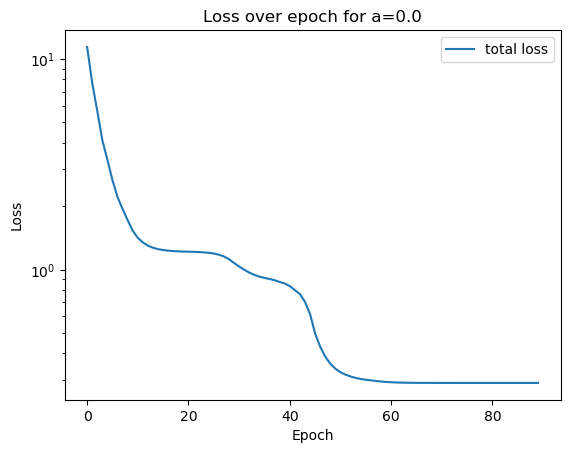

For a = 0.0, omega converged to w = 0.76552 -0.18239i  and to A = 4.00000 + 0.00000i
 
LFBGS: a = 0.1, loss at iteration 1 = 11.09554
LFBGS: a = 0.1, loss at iteration 10 = 1.32499
LFBGS: a = 0.1, loss at iteration 20 = 0.43038
LFBGS: a = 0.1, loss at iteration 30 = 0.36663
LFBGS: a = 0.1, loss at iteration 40 = 0.36558
LFBGS: a = 0.1, loss at iteration 50 = 0.36555
LFBGS: a = 0.1, loss at iteration 60 = 0.35785
LFBGS: a = 0.1, loss at iteration 70 = 0.24432
LFBGS: a = 0.1, loss at iteration 80 = 0.14196
LFBGS: a = 0.1, loss at iteration 90 = 0.05991
LFBGS: a = 0.1, loss at iteration 100 = 0.03145
LFBGS: a = 0.1, loss at iteration 110 = 0.03060
LFBGS: a = 0.1, loss at iteration 120 = 0.02943
LFBGS: a = 0.1, loss at iteration 130 = 0.02858
LFBGS: a = 0.1, loss at iteration 140 = 0.02237
LFBGS: a = 0.1, loss at iteration 150 = 0.01950
LFBGS: a = 0.1, loss at iteration 160 = 0.01939
LFBGS: a = 0.1, loss at iteration 170 = 0.01941
LFBGS: a = 0.1, loss at iteration 180 = 0.01946
LFBGS: a = 

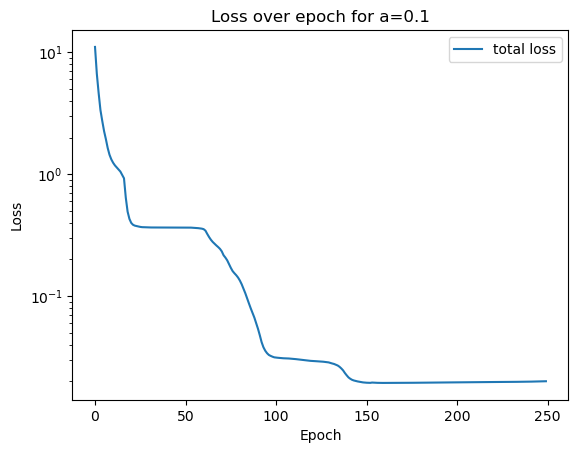

For a = 0.1, omega converged to w = 0.74966 -0.17767i  and to A = 3.99812 + 0.00066i
 
LFBGS: a = 0.2, loss at iteration 1 = 11.03502
LFBGS: a = 0.2, loss at iteration 10 = 1.45685
LFBGS: a = 0.2, loss at iteration 20 = 0.49873
LFBGS: a = 0.2, loss at iteration 30 = 0.45476
LFBGS: a = 0.2, loss at iteration 40 = 0.45372
LFBGS: a = 0.2, loss at iteration 50 = 0.43706
LFBGS: a = 0.2, loss at iteration 60 = 0.34517
LFBGS: a = 0.2, loss at iteration 70 = 0.24374
LFBGS: a = 0.2, loss at iteration 80 = 0.18292
LFBGS: a = 0.2, loss at iteration 90 = 0.06627
LFBGS: a = 0.2, loss at iteration 100 = 0.05580
LFBGS: a = 0.2, loss at iteration 110 = 0.05122
LFBGS: a = 0.2, loss at iteration 120 = 0.04862
LFBGS: a = 0.2, loss at iteration 130 = 0.04231
LFBGS: a = 0.2, loss at iteration 140 = 0.03731
LFBGS: a = 0.2, loss at iteration 150 = 0.03720
LFBGS: a = 0.2, loss at iteration 160 = 0.03719


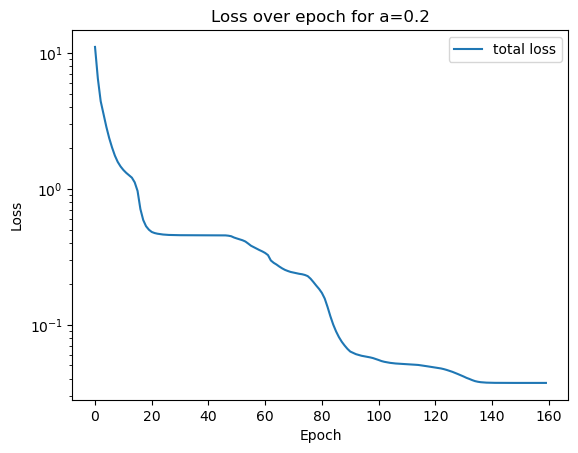

For a = 0.2, omega converged to w = 0.75920 -0.17635i  and to A = 3.99325 + 0.00361i
 
LFBGS: a = 0.3, loss at iteration 1 = 10.89921
LFBGS: a = 0.3, loss at iteration 10 = 1.41310
LFBGS: a = 0.3, loss at iteration 20 = 0.56940
LFBGS: a = 0.3, loss at iteration 30 = 0.56340
LFBGS: a = 0.3, loss at iteration 40 = 0.56301
LFBGS: a = 0.3, loss at iteration 50 = 0.54740
LFBGS: a = 0.3, loss at iteration 60 = 0.43977
LFBGS: a = 0.3, loss at iteration 70 = 0.25384
LFBGS: a = 0.3, loss at iteration 80 = 0.19618
LFBGS: a = 0.3, loss at iteration 90 = 0.12134
LFBGS: a = 0.3, loss at iteration 100 = 0.08715
LFBGS: a = 0.3, loss at iteration 110 = 0.07679
LFBGS: a = 0.3, loss at iteration 120 = 0.07348
LFBGS: a = 0.3, loss at iteration 130 = 0.07132
LFBGS: a = 0.3, loss at iteration 140 = 0.07050
LFBGS: a = 0.3, loss at iteration 150 = 0.07049


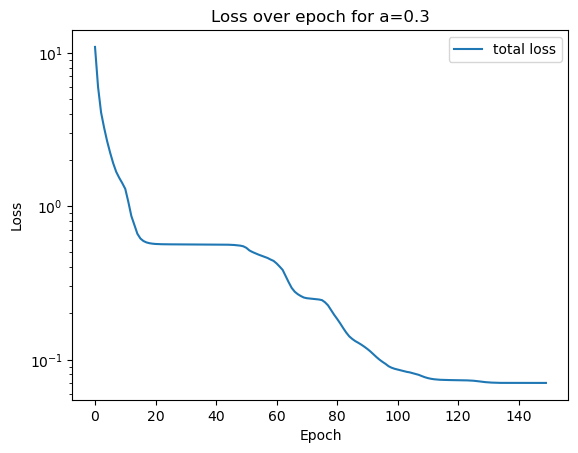

For a = 0.3, omega converged to w = 0.77823 -0.17331i  and to A = 3.98218 + 0.00855i
 
LFBGS: a = 0.4, loss at iteration 1 = 10.00041
LFBGS: a = 0.4, loss at iteration 10 = 1.25620
LFBGS: a = 0.4, loss at iteration 20 = 0.75512
LFBGS: a = 0.4, loss at iteration 30 = 0.73437
LFBGS: a = 0.4, loss at iteration 40 = 0.73307
LFBGS: a = 0.4, loss at iteration 50 = 0.70518
LFBGS: a = 0.4, loss at iteration 60 = 0.34970
LFBGS: a = 0.4, loss at iteration 70 = 0.12642
LFBGS: a = 0.4, loss at iteration 80 = 0.09988
LFBGS: a = 0.4, loss at iteration 90 = 0.09932
LFBGS: a = 0.4, loss at iteration 100 = 0.09859
LFBGS: a = 0.4, loss at iteration 110 = 0.09832
LFBGS: a = 0.4, loss at iteration 120 = 0.09831


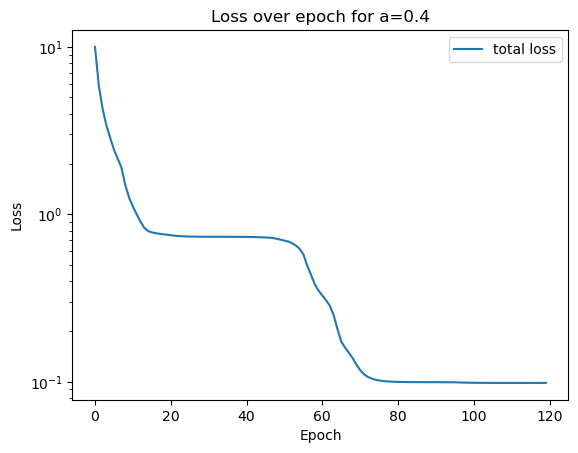

For a = 0.4, omega converged to w = 0.80586 -0.16674i  and to A = 3.96717 + 0.01511i
 
LFBGS: a = 0.45, loss at iteration 1 = 9.63180
LFBGS: a = 0.45, loss at iteration 10 = 2.40453
LFBGS: a = 0.45, loss at iteration 20 = 1.00644
LFBGS: a = 0.45, loss at iteration 30 = 0.94676
LFBGS: a = 0.45, loss at iteration 40 = 0.90428
LFBGS: a = 0.45, loss at iteration 50 = 0.46021
LFBGS: a = 0.45, loss at iteration 60 = 0.44770
LFBGS: a = 0.45, loss at iteration 70 = 0.38284
LFBGS: a = 0.45, loss at iteration 80 = 0.20802
LFBGS: a = 0.45, loss at iteration 90 = 0.14760
LFBGS: a = 0.45, loss at iteration 100 = 0.11294
LFBGS: a = 0.45, loss at iteration 110 = 0.10667
LFBGS: a = 0.45, loss at iteration 120 = 0.10442
LFBGS: a = 0.45, loss at iteration 130 = 0.10308
LFBGS: a = 0.45, loss at iteration 140 = 0.10227
LFBGS: a = 0.45, loss at iteration 150 = 0.10109
LFBGS: a = 0.45, loss at iteration 160 = 0.09893
LFBGS: a = 0.45, loss at iteration 170 = 0.09877
LFBGS: a = 0.45, loss at iteration 180 = 0

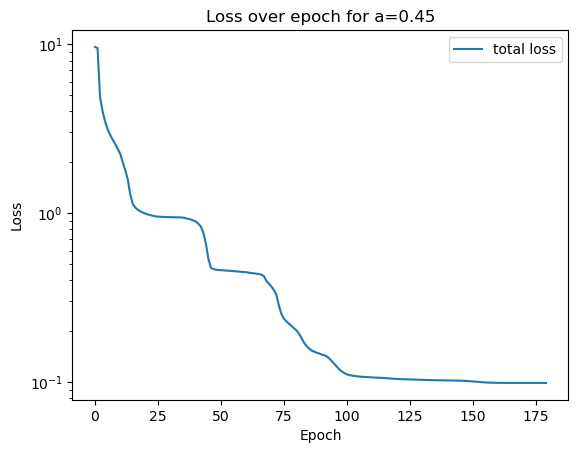

For a = 0.45, omega converged to w = 0.82579 -0.15600i  and to A = 3.95366 + 0.01903i
 
LFBGS: a = 0.49, loss at iteration 1 = 10.53452
LFBGS: a = 0.49, loss at iteration 10 = 2.29415
LFBGS: a = 0.49, loss at iteration 20 = 1.94077
LFBGS: a = 0.49, loss at iteration 30 = 1.87013
LFBGS: a = 0.49, loss at iteration 40 = 1.03668
LFBGS: a = 0.49, loss at iteration 50 = 0.72846
LFBGS: a = 0.49, loss at iteration 60 = 0.42743
LFBGS: a = 0.49, loss at iteration 70 = 0.33053
LFBGS: a = 0.49, loss at iteration 80 = 0.23454
LFBGS: a = 0.49, loss at iteration 90 = 0.18028
LFBGS: a = 0.49, loss at iteration 100 = 0.16927
LFBGS: a = 0.49, loss at iteration 110 = 0.16281
LFBGS: a = 0.49, loss at iteration 120 = 0.16160
LFBGS: a = 0.49, loss at iteration 130 = 0.16135
LFBGS: a = 0.49, loss at iteration 140 = 0.16125
LFBGS: a = 0.49, loss at iteration 150 = 0.16116
LFBGS: a = 0.49, loss at iteration 160 = 0.16100
LFBGS: a = 0.49, loss at iteration 170 = 0.16096
LFBGS: a = 0.49, loss at iteration 180 =

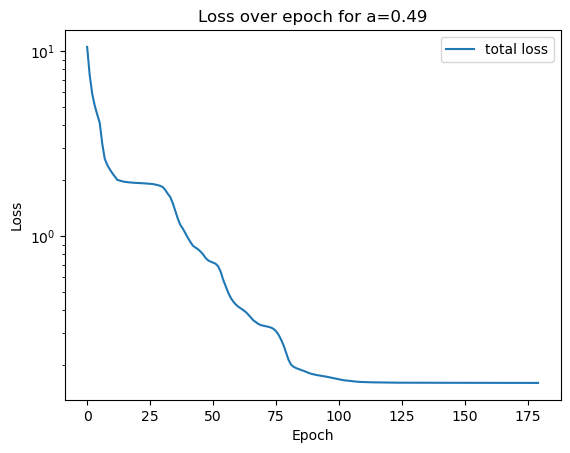

For a = 0.49, omega converged to w = 0.84581 -0.14578i  and to A = 3.94426 + 0.02124i
 
LFBGS: a = 0.4999, loss at iteration 1 = 11.99546
LFBGS: a = 0.4999, loss at iteration 10 = 4.19887
LFBGS: a = 0.4999, loss at iteration 20 = 3.98283
LFBGS: a = 0.4999, loss at iteration 30 = 2.54821
LFBGS: a = 0.4999, loss at iteration 40 = 1.80273
LFBGS: a = 0.4999, loss at iteration 50 = 1.27449
LFBGS: a = 0.4999, loss at iteration 60 = 1.03015
LFBGS: a = 0.4999, loss at iteration 70 = 0.82953
LFBGS: a = 0.4999, loss at iteration 80 = 0.69320
LFBGS: a = 0.4999, loss at iteration 90 = 0.63815
LFBGS: a = 0.4999, loss at iteration 100 = 0.54716
LFBGS: a = 0.4999, loss at iteration 110 = 0.45369
LFBGS: a = 0.4999, loss at iteration 120 = 0.40802
LFBGS: a = 0.4999, loss at iteration 130 = 0.36444
LFBGS: a = 0.4999, loss at iteration 140 = 0.33016
LFBGS: a = 0.4999, loss at iteration 150 = 0.25608
LFBGS: a = 0.4999, loss at iteration 160 = 0.22085
LFBGS: a = 0.4999, loss at iteration 170 = 0.20374
LFBG

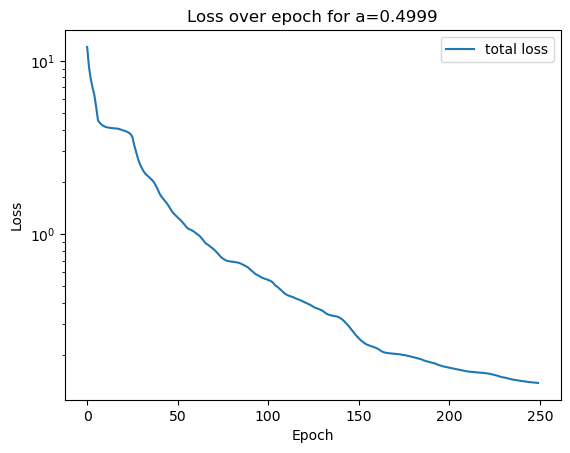

For a = 0.4999, omega converged to w = 0.85096 -0.14476i  and to A = 3.93622 + 0.02302i
 


In [55]:
# Set double precision as standard for torch
#torch.set_default_dtype(torch.float32)

# sample locations over the problem domain
N_x = 100 
N_u = 100
#Here I define x = 1 / r. However, I define it in a domain that goes from r = r_plus to r = infinity
# This means that x goes from 0 to 1/ r_plus -> Hence I will define each spacial domain for each a
u = torch.linspace(-1,1,N_u).view(-1,1).requires_grad_(True)

a_k_list = [0.0,0.1,0.2,0.3,0.4,0.45,0.49,0.4999]
#a_k_list = [0.4999]

#Extract List of real and imaginary values of w
w_real_list_LBFGS = []
w_img_list_LBFGS = [] 

for a in a_k_list:

    #Define the spacial domain for each a
    r_plus = (1 + np.sqrt(1-4*a**2)) / 2
    x = torch.linspace(0,1/r_plus,N_x).view(-1,1).requires_grad_(True)
    
    # define the neural network to train
    l,m = 2,0
    model = NeuralNetwork(l,m)

    # Add parameters to L-BFGS optimizer
    optimiser_tuning = torch.optim.LBFGS(model.parameters(), lr = 0.01)
    
    #Initialize the model of the loss
    model_loss = CustomLoss(model,a)
    
    #Initialize (empty lists) that store values for plots for each a
    loss_list = []

    #Define the closure for the LBFGS optimiser
    def closure():
        optimiser_tuning.zero_grad()
        loss = model_loss(x,u)
        loss.backward()
        return loss
    
    #Train the model with the fine tuning optimiser
    for i in range(250): 
        optimiser_tuning.step(closure)

        #record values of loss function
        loss_list.append(closure().item())
        #Print the loss every 10 iterations
        if(((i+1)%10 == 0) or (i == 0) ):
            
            print(f"LFBGS: a = {a}, loss at iteration {i+1} = {closure().item():.5f}")

            # If the two last values of the loss are the same, within a tolerance of 1e-5, we stop the training:
            if i > 0 and abs(loss_list[-1] - loss_list[-10]) < 1e-5:
                break
            
    

    
    #Plot of the losses for each interesting a:

    plot_losses(loss_list, a, optimiser_tuning = False)
    print(f"For a = {a}, omega converged to w = {model.w_real.item():.5f} {model.w_img.item():.5f}i  and to A = {model.A_real.item():.5f} + {model.A_img.item():.5f}i")
    print(f" ")
    #Extract List of real and imaginary values of w
    w_real_list_LBFGS.append(model.w_real.item())
    w_img_list_LBFGS.append(model.w_img.item())

In [56]:
# Check results for 250 iterations of LBFGS:
print_results(np.array(w_real_list_LBFGS),np.array(w_img_list_LBFGS))

Real part of w: 0.76552, Imaginary part of w: -0.18239, Error real: 2.43282%, Error imaginary: 2.50496%, Average error: 2.46889%
Real part of w: 0.74966, Imaginary part of w: -0.17767, Error real: -0.07917%, Error imaginary: 0.15500%, Average error: 0.11708%
Real part of w: 0.75920, Imaginary part of w: -0.17635, Error real: -0.02143%, Error imaginary: 0.40080%, Average error: 0.21111%
Real part of w: 0.77823, Imaginary part of w: -0.17331, Error real: 0.27278%, Error imaginary: 0.76785%, Average error: 0.52032%
Real part of w: 0.80586, Imaginary part of w: -0.16674, Error real: 0.25113%, Error imaginary: 1.47771%, Average error: 0.86442%
Real part of w: 0.82579, Imaginary part of w: -0.15600, Error real: 0.21555%, Error imaginary: -0.62084%, Average error: 0.41819%
Real part of w: 0.84581, Imaginary part of w: -0.14578, Error real: 0.15389%, Error imaginary: -0.87698%, Average error: 0.51543%
Real part of w: 0.85096, Imaginary part of w: -0.14476, Error real: 0.08573%, Error imaginary